# Working with Observational Frames

In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from astropy import units as u
import time

import blimpy as bl

import sys, os, glob
sys.path.insert(0, "../../")
import setigen as stg

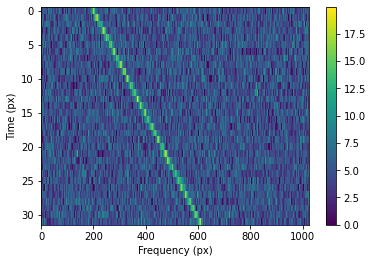

In [10]:
%matplotlib inline
from astropy import units as u
import sys, os, glob
sys.path.insert(0, "../../")
import setigen as stg

frame = stg.Frame(fchans=1024*u.pixel,
                  tchans=32*u.pixel,
                  df=2.7939677238464355*u.Hz,
                  dt=18.25361108*u.s,
                  fch1=6095.214842353016*u.MHz)
frame.add_noise(x_mean=5, x_std=2, x_min=0)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(200),
                                   drift_rate=2*u.Hz/u.s),
                 stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                 stg.gaussian_f_profile(width=40*u.Hz),
                 stg.constant_bp_profile(level=1))

frame.render()
plt.savefig('../../docs/source/images/gs_synth_render.pdf', bbox_inches='tight')
plt.show()

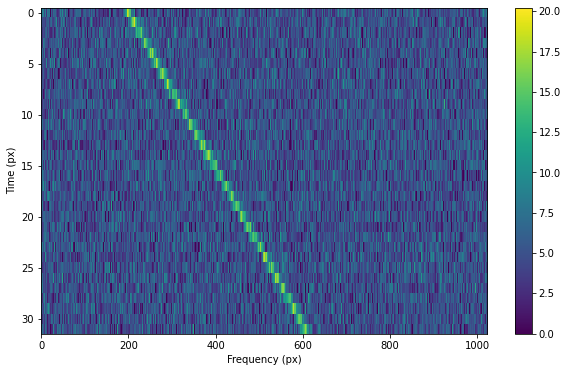

In [20]:

frame = stg.Frame(fchans=1024*u.pixel,
                  tchans=32*u.pixel,
                  df=2.7939677238464355*u.Hz,
                  dt=18.25361108*u.s,
                  fch1=6095.214842353016*u.MHz)
noise = frame.add_noise(x_mean=5, x_std=2, x_min=0)
signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=200),
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                          stg.gaussian_f_profile(width=40*u.Hz),
                          stg.constant_bp_profile(level=1))

plt.figure(figsize=(10, 6))
frame.render()
plt.savefig('../../docs/source/images/example.png', bbox_inches='tight')
plt.show()

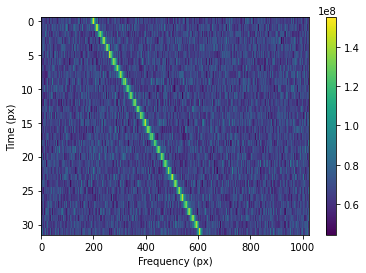

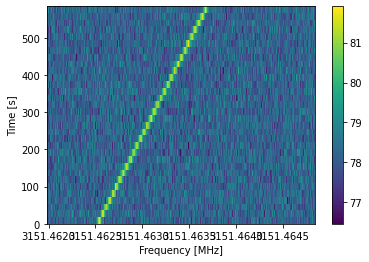

In [18]:
frame = stg.Frame(fil=fil)
frame.add_signal(stg.constant_path(f_start=frame.get_frequency(200),
                                   drift_rate=2*u.Hz/u.s),
                 stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                 stg.gaussian_f_profile(width=40*u.Hz),
                 stg.constant_bp_profile(level=1))


frame.render()
plt.savefig('../../docs/source/images/gs_obs_render.pdf', bbox_inches='tight')
plt.show()

frame.bl_render()
plt.savefig('../../docs/source/images/gs_obs_bl_render.pdf', bbox_inches='tight')
plt.show()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
# Using high resolution BL data products from one compute node
obs_fn = '/datax/scratch/bbrzycki/old/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil'
bl.read_header(obs_fn)

{b'rawdatafile': b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw',
 b'source_name': b'DIAG_SGR_B2',
 b'machine_id': 20,
 b'telescope_id': 6,
 b'src_raj': <Angle 17.78900667 hourangle>,
 b'src_dej': <Angle -28.3854 deg>,
 b'az_start': 0.0,
 b'za_start': 0.0,
 b'data_type': 1,
 b'fch1': 3151.464842353016,
 b'foff': -2.7939677238464355e-06,
 b'nchans': 67108864,
 b'nbeams': 1,
 b'ibeam': 1,
 b'nbits': 32,
 b'tstart': 58331.14332175926,
 b'tsamp': 18.253611008,
 b'nifs': 1}

In [4]:
def fil_to_frame(fil_fn, f_start=None, f_stop=None):
    fil = bl.Waterfall(fil_fn, f_start=f_start, f_stop=f_stop)
        
    # Fix some header values
    fil.header[b'fch1'] = fil.file_header[b'fch1'] = f_stop
    fil.header[b'nchans'] = fil.file_header[b'nchans'] = 1024
    
    return fil

In [15]:
start = time.time()
frame_itr = stg.split_fil_generator(obs_fn, fchans=1024, tchans=32)
print(time.time() - start)

0.000186920166015625


In [16]:
time0 = time.time()

fil = next(frame_itr)
time1 = time.time()

frame = stg.Frame(fil=fil)
time2 = time.time()

# min_freq = stg.min_freq(fil)
# max_freq =  stg.max_freq(fil)
# print(min_freq, max_freq)

time1 - time0, time2 - time1

blimpy.io.file_wrapper INFO     Skipping loading data ...


(0.008493661880493164, 0.008766651153564453)

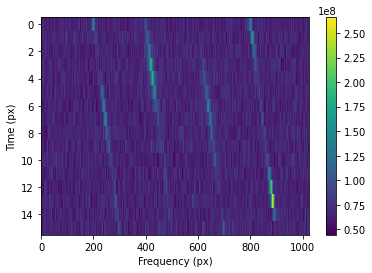

In [6]:
num_signals = 4

p = 2
tscint = 50
rho = stg.get_rho(frame.ts, tscint, p)

Z = stg.build_Z(rho, frame.tchans * num_signals)
Y = stg.get_Y(Z)
# print(stg.autocorrelation(Y, p+1)[1:])


signal = frame.add_signal(stg.constant_path(f_start=frame.fs[200], drift_rate=1*u.Hz/u.s),
                          Y[:frame.tchans] * frame.get_intensity(25),
                          stg.gaussian_f_profile(width=30*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame.add_signal(stg.constant_path(f_start=frame.fs[400], drift_rate=1*u.Hz/u.s),
                          Y[frame.tchans:2*frame.tchans] * frame.get_intensity(25),
                          stg.lorentzian_f_profile(width=30*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame.add_signal(stg.constant_path(f_start=frame.fs[600], drift_rate=1*u.Hz/u.s),
                          Y[2*frame.tchans:3*frame.tchans] * frame.get_intensity(25),
                          stg.lorentzian_f_profile(width=30*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame.add_signal(stg.constant_path(f_start=frame.fs[800], drift_rate=1*u.Hz/u.s),
                          Y[3*frame.tchans:] * frame.get_intensity(25),
                          stg.gaussian_f_profile(width=30*u.Hz),
                          stg.constant_bp_profile(level=1))

frame.show()

In [45]:
vars(frame)

{'fil': Waterfall data: /datax/scratch/bbrzycki/old/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil,
 'header': {b'rawdatafile': b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw',
  b'source_name': b'DIAG_SGR_B2',
  b'machine_id': 20,
  b'telescope_id': 6,
  b'src_raj': <Angle 17.78900667 hourangle>,
  b'src_dej': <Angle -28.3854 deg>,
  b'az_start': 0.0,
  b'za_start': 0.0,
  b'data_type': 1,
  b'fch1': 3151.464842353016,
  b'foff': -2.7939677238464355e-06,
  b'nchans': 67108864,
  b'nbeams': 1,
  b'ibeam': 1,
  b'nbits': 32,
  b'tstart': 58331.14332175926,
  b'tsamp': 18.253611008,
  b'nifs': 1},
 'tchans': 16,
 'fchans': 1024,
 'df': 2.7939677238464355,
 'fch1': 3151464842.353016,
 'data': array([[55204184., 66280250., 70978490., ..., 73700880., 61869212.,
         69472216.],
        [67721144., 74628330., 84131430., ..., 61497816., 66798480.,
         61100104.],
        [66931824., 69839320., 68456400., ..., 75384360., 66016130.,
         66591636.],
        ...,
    

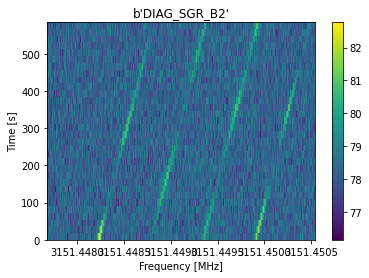

In [25]:
frame.bl_show()

In [7]:
plt.plot(np.arange(10)**2)

In [16]:
frame.save_pickle('test.pickle')

{}

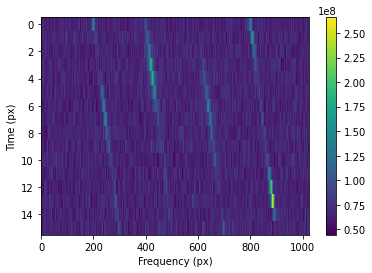

In [17]:
frame2 = stg.Frame.load_pickle('test.pickle')
frame2.show()
frame2.metadata

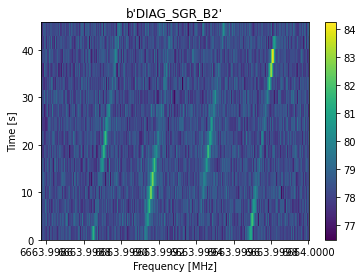

In [18]:
frame2.bl_show()

In [64]:
time0 = time.time()

fil = fil_to_frame(obs_fn, f_start=min_freq, f_stop=max_freq)
time1 = time.time()

frame = stg.Frame(fil=fil)
time2 = time.time()

time1 - time0, time2 - time1

(0.004677534103393555, 0.007887601852416992)

In [50]:
def split_fil_generator(fil_fn, f_window, f_shift=None):
    fch1 = read_header(fil_fn)[b'fch1']
    nchans = read_header(fil_fn)[b'nchans']
    df = read_header(fil_fn)[b'foff']

    if f_shift is None:
        f_shift = f_window

    # Note that df is negative!
    f_start = fch1 + f_window * df
    f_stop = fch1

    # Iterates down frequencies, starting from highest
    while f_start >= fch1 + nchans * df:
        split_fil = Waterfall(fil_fn, f_start=f_start, f_stop=f_stop)
        
        # Fix some header values
        split_fil.header[b'fch1'] = split_fil.file_header[b'fch1'] = f_stop
        split_fil.header[b'nchans'] = split_fil.file_header[b'nchans'] = f_window
        
        yield stg.Frame(fil=split_fil)

        f_start += f_shift * df
        f_stop += f_shift * df

In [51]:
start = time.time()
frame_itr = split_fil_generator(obs_fn, 1024)
print(time.time() - start)

0.00017213821411132812


In [58]:
time0 = time.time()

frame = next(frame_itr)
time1 = time.time()

time1 - time0

0.011955976486206055

In [67]:
minfreq, maxfreq

(3151.4448151923716, 3151.447676215321)

In [66]:
fil = bl.Waterfall(obs_fn, f_start=minfreq, f_stop=maxfreq)
stg.minfreq(fil), stg.maxfreq(fil)

(2963.964842353016, 3151.464842353016)

In [87]:
start = time.time()
fil = bl.Waterfall(obs_fn, f_start=minfreq, f_stop=maxfreq,
                   load_data=False)
print(time.time() - start)
fil.container.f_start, fil.container.f_stop

blimpy.io.file_wrapper INFO     Skipping loading data ...
0.004248857498168945


(3151.4448151923716, 3151.447676215321)

In [69]:
fil._update_header
stg.minfreq(fil), stg.maxfreq(fil)

(2963.964842353016, 3151.464842353016)

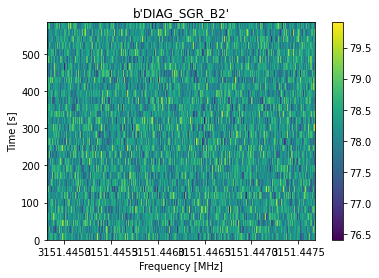

In [70]:
fil.plot_waterfall()

In [71]:
fil.info()


--- File Info ---
  b'rawdatafile' : b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw'
  b'source_name' :                   b'DIAG_SGR_B2'
   b'machine_id' :                               20
 b'telescope_id' :                                6
      b'src_raj' :                    17h47m20.424s
      b'src_dej' :                    -28d23m07.44s
     b'az_start' :                              0.0
     b'za_start' :                              0.0
    b'data_type' :                                1
         b'fch1' :                3151.464842353016
         b'foff' :          -2.7939677238464355e-06
       b'nchans' :                         67108864
       b'nbeams' :                                1
        b'ibeam' :                                1
        b'nbits' :                               32
   tstart (ISOT) :          2018-08-01T03:26:23.000
    tstart (MJD) :                58331.14332175926
        b'tsamp' :                     18.253611008
         b'nifs' :             

In [75]:
fil.container

In [95]:
fil.container.selection_shape

(32, 1, 1024)

In [77]:
list(vars(fil.container).keys())

['t_begin',
 't_end',
 'header_keywords_types',
 'filename',
 'load_data',
 'header',
 'file_size_bytes',
 'idx_data',
 'n_channels_in_file',
 'n_beams_in_file',
 'n_pols_in_file',
 '_n_bytes',
 '_d_type',
 'n_ints_in_file',
 'file_shape',
 'f_end',
 'f_begin',
 't_start',
 't_stop',
 'f_start',
 'f_stop',
 'selection_shape',
 'chan_start_idx',
 'chan_stop_idx',
 'freq_axis',
 'time_axis',
 'beam_axis',
 'MAX_DATA_ARRAY_SIZE',
 'large_file',
 'data']

In [83]:
vars(fil.container)

{'t_begin': 0,
 't_end': 32,
 'header_keywords_types': {b'telescope_id': b'<l',
  b'machine_id': b'<l',
  b'data_type': b'<l',
  b'barycentric': b'<l',
  b'pulsarcentric': b'<l',
  b'nbits': b'<l',
  b'nsamples': b'<l',
  b'nchans': b'<l',
  b'nifs': b'<l',
  b'nbeams': b'<l',
  b'ibeam': b'<l',
  b'rawdatafile': b'str',
  b'source_name': b'str',
  b'az_start': b'<d',
  b'za_start': b'<d',
  b'tstart': b'<d',
  b'tsamp': b'<d',
  b'fch1': b'<d',
  b'foff': b'<d',
  b'refdm': b'<d',
  b'period': b'<d',
  b'src_raj': b'angle',
  b'src_dej': b'angle'},
 'filename': '/datax/scratch/bbrzycki/old/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil',
 'load_data': True,
 'header': {b'rawdatafile': b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw',
  b'source_name': b'DIAG_SGR_B2',
  b'machine_id': 20,
  b'telescope_id': 6,
  b'src_raj': <Angle 17.78900667 hourangle>,
  b'src_dej': <Angle -28.3854 deg>,
  b'az_start': 0.0,
  b'za_start': 0.0,
  b'data_type': 1,
  b'fch1': 3151.46484235

In [84]:
fil = bl.Waterfall(obs_fn)
vars(fil.container)

blimpy.io.file_wrapper WARNING  Selection size of 8.00 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.


{'t_begin': 0,
 't_end': 32,
 'header_keywords_types': {b'telescope_id': b'<l',
  b'machine_id': b'<l',
  b'data_type': b'<l',
  b'barycentric': b'<l',
  b'pulsarcentric': b'<l',
  b'nbits': b'<l',
  b'nsamples': b'<l',
  b'nchans': b'<l',
  b'nifs': b'<l',
  b'nbeams': b'<l',
  b'ibeam': b'<l',
  b'rawdatafile': b'str',
  b'source_name': b'str',
  b'az_start': b'<d',
  b'za_start': b'<d',
  b'tstart': b'<d',
  b'tsamp': b'<d',
  b'fch1': b'<d',
  b'foff': b'<d',
  b'refdm': b'<d',
  b'period': b'<d',
  b'src_raj': b'angle',
  b'src_dej': b'angle'},
 'filename': '/datax/scratch/bbrzycki/old/data/blc00_guppi_58331_12383_DIAG_SGR_B2_0014.gpuspec.0000.fil',
 'load_data': True,
 'header': {b'rawdatafile': b'guppi_58331_12383_DIAG_SGR_B2_0014.0000.raw',
  b'source_name': b'DIAG_SGR_B2',
  b'machine_id': 20,
  b'telescope_id': 6,
  b'src_raj': <Angle 17.78900667 hourangle>,
  b'src_dej': <Angle -28.3854 deg>,
  b'az_start': 0.0,
  b'za_start': 0.0,
  b'data_type': 1,
  b'fch1': 3151.46484235

In [93]:
fil.data[:, 0, :].shape

(32, 1024)

In [94]:
a = 1000 - 100 * 1.5
print(a)
b = np.arange(a, a + 100 * 1.5, 1.5)
b[0], b[-1]

850.0


(850.0, 998.5)